#### In this notebook we will try to use the **pyhmmer** package to realign the sequences generated by esm to the one of the msa. 

In [1]:
import torch
import numpy as np
import scipy
import os
import sys
import biotite.structure
from biotite.structure.io import pdbx, pdb
from biotite.structure.residues import get_residues
from biotite.structure import filter_backbone
from biotite.structure import get_chains
from biotite.sequence import ProteinSequence
from typing import Sequence, Tuple, List
from Bio import SeqIO


git_folder = '/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/Inverse_Folding'
esm_folder = '/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/esm/'
sys.path.insert(1, os.path.join(git_folder, 'model'))
sys.path.insert(1, os.path.join(git_folder, 'util'))

sys.path.insert(1, esm_folder)
import esm
#import esm.inverse_folding
#from esm.inverse_folding import util
import esm.pretrained as pretrained

## I import this to try to get deeper on the sampling perplexity
from esm.inverse_folding.features import DihedralFeatures
from esm.inverse_folding.gvp_encoder import GVPEncoder
from esm.inverse_folding.gvp_utils import unflatten_graph
from esm.inverse_folding.gvp_transformer_encoder import GVPTransformerEncoder
from esm.inverse_folding.transformer_decoder import TransformerDecoder
#from esm.inverse_folding.util import rotate, CoordBatchConverter 


#### Code for model with PLL ########
#from potts_decoder import PottsDecoder
#### Code for model with NCE ##########
from potts_decoder import PottsDecoder
from ioutils import read_fasta, read_encodings
from encoded_protein_dataset_new import get_embedding, EncodedProteinDataset_new, EncodedProteinDataset_aux, collate_fn_new#, dynamic_collate_fn


from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torch.nn.functional import one_hot

from collections import defaultdict

import matplotlib.pyplot as plt
import pyhmmer



In [2]:
def load_structure(fpath, chain=None):
    """
    Args:
        fpath: filepath to either pdb or cif file
        chain: the chain id or list of chain ids to load
    Returns:
        biotite.structure.AtomArray
    """
    with open(fpath) as fin:
        pdbf = pdb.PDBFile.read(fin)
    structure = pdb.get_structure(pdbf, model=1)
    bbmask = filter_backbone(structure)
    structure = structure[bbmask]
    all_chains = get_chains(structure)
    if len(all_chains) == 0:
        raise ValueError('No chains found in the input file.')
    if chain is None:
        chain_ids = all_chains
    elif isinstance(chain, list):
        chain_ids = chain
    else:
        chain_ids = [chain] 
    for chain in chain_ids:
        if chain not in all_chains:
            raise ValueError(f'Chain {chain} not found in input file')
    chain_filter = [a.chain_id in chain_ids for a in structure]
    structure = structure[chain_filter]
    return structure

def extract_coords_from_structure(structure: biotite.structure.AtomArray):
    """
    Args:
        structure: An instance of biotite AtomArray
    Returns:
        Tuple (coords, seq)
            - coords is an L x 3 x 3 array for N, CA, C coordinates
            - seq is the extracted sequence
    """
    coords = get_atom_coords_residuewise(["N", "CA", "C"], structure)
    residue_identities = get_residues(structure)[1]
    seq = ''.join([ProteinSequence.convert_letter_3to1(r) for r in residue_identities])
    return coords, seq

def get_atom_coords_residuewise(atoms: List[str], struct: biotite.structure.AtomArray):
    """
    Example for atoms argument: ["N", "CA", "C"]
    """
    def filterfn(s, axis=None):
        filters = np.stack([s.atom_name == name for name in atoms], axis=1)
        sum = filters.sum(0)
        if not np.all(sum <= np.ones(filters.shape[1])):
            raise RuntimeError("structure has multiple atoms with same name")
        index = filters.argmax(0)
        coords = s[index].coord
        coords[sum == 0] = float("nan")
        return coords

    return biotite.structure.apply_residue_wise(struct, struct, filterfn)

def get_loss_new(decoder, inputs, eta):
    """eta is the multiplicative term in front of the penalized negative pseudo-log-likelihood"""
    msas, encodings, padding_mask  = [input.to(device) for input in inputs]
    B, M, N = msas.shape
    #print(f"encodings' shape{encodings.shape}, padding mask:{padding_mask.shape}")
    param_embeddings, fields = decoder.forward_new(encodings, padding_mask)
    msas_embedded = embedding(msas)

    # get npll
    npll = get_npll2(msas_embedded, param_embeddings, fields, N, q)
    padding_mask_inv = (~padding_mask)
    # multiply with the padding mask to filter non-existing residues (this is probably not necessary)       
    npll = npll * padding_mask_inv.unsqueeze(1)
    npll_mean = torch.sum(npll) / (M * torch.sum(padding_mask_inv))
    
    Q = torch.einsum('bkuia, buhia->bkhia', 
                param_embeddings.unsqueeze(2), param_embeddings.unsqueeze(1)).sum(axis=-1)
    penalty = eta*(torch.sum(torch.sum(Q,axis=-1)**2) - torch.sum(Q**2) + torch.sum(fields**2))/B
    loss_penalty = npll_mean + penalty
    return loss_penalty, npll_mean.item() 

def get_loss(decoder, inputs, eta):
    """eta is the multiplicative term in front of the penalized negative pseudo-log-likelihood"""
    msas, encodings, padding_mask  = [input.to(device) for input in inputs]
    B, M, N = msas.shape
    #print(f"encodings' shape{encodings.shape}, padding mask:{padding_mask.shape}")
    couplings, fields = decoder(encodings, padding_mask)

    # embed and reshape to (B, M, N*q)
    msas_embedded = embedding(msas).view(B, M, -1)

    # get npll
    npll = get_npll(msas_embedded, couplings, fields, N, q)
    padding_mask_inv = (~padding_mask)

    # multiply with the padding mask to filter non-existing residues (this is probably not necessary)       
    npll = npll * padding_mask_inv.unsqueeze(1)
    penalty = eta*(torch.sum(couplings**2) + torch.sum(fields**2))/B

    # the padding mask does not contain the msa dimension so we need to multiply by M
    npll_mean = torch.sum(npll) / (M * torch.sum(padding_mask_inv))
    loss_penalty = npll_mean + penalty
    return loss_penalty, npll_mean.item() 
    #return loss_penalty

def get_loss_loader(decoder, loader, eta):

    decoder.eval()
    losses = 0
    iterator = 0
    with torch.no_grad():
        for inputs in loader:
            iterator+=1
            _, npll = get_loss_new(decoder, inputs, eta) 
            losses+=npll
    
    return losses/iterator

def compute_covariance(msa, q):
    """
    Compute covariance matrix of a given MSA having q different amino acids
    """
    M, N = msa.shape

    # One hot encode classes and reshape to create data matrix
    D = torch.flatten(one_hot(msa, num_classes=q), start_dim=1).to(torch.float32)

    # Remove one amino acid
    D = D.view(M, N, q)[:, :, :q-1].flatten(1)

    # Compute bivariate frequencies
    bivariate_freqs = D.T @ D / M
    
    # Compute product of univariate frequencies
    univariate_freqs = torch.diagonal(bivariate_freqs).view(N*(q-1), 1) @ torch.diagonal(bivariate_freqs).view(1, N*(q-1))

    return bivariate_freqs - univariate_freqs

In [3]:
device='cpu'
mutational_dir = '/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/Mutational_Data'
msas_folder = '/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/Mutational_Data/alphafold_results_wildtype'

protein_original_DMS = 'YAP1_HUMAN_1_b0.5.a2m.wildtype.fasta'
structure_name = 'YAP1_HUMAN_1_b0.5.a2m_unrelaxed_rank_1_model_5.pdb'

folder_fasta = os.path.join(mutational_dir, 'alignments')
native_path = os.path.join(folder_fasta, protein_original_DMS)
structure_folder = os.path.join(mutational_dir, 'alphafold_results_wildtype')
structure_path = os.path.join(structure_folder, structure_name)

num_seq = read_fasta(native_path, mutated_exp=True)
structure =  load_structure(structure_path)
coords, native_seq = extract_coords_from_structure(structure)
coords=torch.tensor(coords).to(device)

In [3]:
alphabet='ACDEFGHIKLMNPQRSTVWY-'
default_index = alphabet.index('-')
aa_index = defaultdict(lambda: default_index, {alphabet[i]: i for i in range(len(alphabet))})
aa_index_inv = dict(map(reversed, aa_index.items()))

In [5]:
import re
fastapath = "/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/Mutational_Data/alphafold_results_wildtype/MSAS_new/YAP1_HUMAN_1_b0.5.a2m.a3m"
with open(fastapath, mode="r") as f:
    lines = f.readlines()
lines = lines[1:]

msa_true = []
for line in range(len(lines)):
    if line%2 == 0:
        ## Take the end of sequence file
        seq_str = lines[line]#[0:-1]
        seq_num = []
        for char in seq_str:
            if char != '\n':
                seq_num.append(aa_index[char])
        if len(seq_num) == 36:
            msa_true.append(seq_num)
        else:
            print("failure")

msa_true = torch.tensor(msa_true)
cov_true = compute_covariance(msa_true[::,::], q=21)


In [6]:
pyhmmer.__version__

'0.8.1'

In [11]:
alphabet_hmm = pyhmmer.easel.Alphabet.amino()
alphabet_hmm

pyhmmer.easel.Alphabet.amino()

In [12]:
with pyhmmer.easel.MSAFile(fastapath, digital=True, alphabet=alphabet_hmm) as msa_file:
    msa = msa_file.read()

In [13]:
len(msa.sequences)

14484

In [14]:
#msa

In [15]:
msa.name = b"YAP-HUMAN"

In [16]:
?pyhmmer.plan7.Builder

Init signature:
pyhmmer.plan7.Builder(
    self,
    alphabet,
    *,
    architecture='fast',
    weighting='pb',
    effective_number='entropy',
    prior_scheme='alpha',
    symfrac=0.5,
    fragthresh=0.5,
    wid=0.62,
    esigma=45.0,
    eid=0.62,
    EmL=200,
    EmN=200,
    EvL=200,
    EvN=200,
    EfL=100,
    EfN=200,
    Eft=0.04,
    seed=42,
    ere=None,
    popen=None,
    pextend=None,
    window_length=None,
    window_beta=None,
)
Docstring:     
A factory for constructing new HMMs from raw sequences.

Attributes:
    alphabet (`~pyhmmer.easel.Alphabet`): The alphabet the builder is
        configured to use to convert sequences to HMMs.
    randomness (`~pyhmmer.easel.Randomness`): The random number generator
        being used by the builder.
    score_matrix (`str`): The name of the substitution matrix used to
        build HMMs for single sequences.
    popen (`float`): The *gap open* probability to use when building
        HMMs from single sequences.
    pext

In [17]:
builder = pyhmmer.plan7.Builder(alphabet_hmm, symfrac=0.0)
background = pyhmmer.plan7.Background(alphabet_hmm)
hmm, _, _ = builder.build_msa(msa, background)

In [18]:
hmm.consensus

'daPLPpGWeeavdpdGrvYYyNheTgettWedPreA'

In [4]:
model, alphabet_esm = pretrained.esm_if1_gvp4_t16_142M_UR50()
model.eval();
model.to(device)
rep = esm.inverse_folding.util.get_encoder_output(model, alphabet_esm, coords)

/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/esm/esm/pretrained.py:174: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


NameError: name 'device' is not defined

In [10]:
model.sample.__globals__['__file__']

'/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/esm/esm/inverse_folding/gvp_transformer.py'

In [15]:
samples_esm = []
samples_str = []
samples_hmm = []
for attempt in range(50):
    print(f"We are at sample {attempt} out of {50}", end="\r")
    sample = model.sample(coords, temperature=1.0)
    name = f"sample{attempt}".encode('ASCII')
    sample_dig = pyhmmer.easel.TextSequence(name = name, sequence=sample).digitize(alphabet_hmm)
    samples_hmm.append(sample_dig)
    samples_str.append(sample)
    seq_num = []
    for char in sample:
        seq_num.append(aa_index[char])
    samples_esm.append(seq_num)

In [98]:
#msa_hmm  = pyhmmer.easel.TextMSA(name=b"msa", sequences=samples_hmm)
#msa_d = msa_hmm.digitize(alphabet_hmm)#

In [24]:
msa_aligned = pyhmmer.hmmer.hmmalign(hmm, samples_hmm, trim=True)

In [32]:
len(msa_aligned.alignment[1])

36

In [27]:
samples_str[0]

'MKSMPEGYLAISDNEGNRQYYNTTTDQISIADPRQE'

In [28]:
for name, aligned in zip(msa_aligned.names, msa_aligned.alignment):
    print(name, " ", aligned[:48], "...")

b'sample0'   ---MPEGYLAISDNEGNRQYYNTTTDQISIADPRQ- ...
b'sample1'   ERPLPEGYTAVSTAEGKTLFIDNNTKQATGIDPR-- ...
b'sample2'   --ALPKGWKKATTASGKQVYYDSKKATVTSKDPR-- ...
b'sample3'   --PLPDGYVEQYTKHGTKIYFDTETQTVTYTDPREA ...
b'sample4'   ---LPDGYVEITTLRGRLLYFDSSRRKVSLVDPR-- ...
b'sample5'   ---NPIGWIQTNTDDGTVVFYNSERDMVTRSDPR-- ...
b'sample6'   ----PIGWVEESDEEGVQFYWNTVQNTRSHEDPR-- ...
b'sample7'   ---LPAGWVAVKNDSGETFFFDSKTNTQSWEDPRQ- ...
b'sample8'   ---MPEGWRAHDNGNGTKFYFDGNNNTSSWFDPR-- ...
b'sample9'   ----PFGWTVVYTKTGKSLYVDKNQNTISGVDPR-- ...
b'sample10'   ---MPAGWLRLFTDQGDQIYFDMNTKTTTWQDPRQ- ...
b'sample11'   -TPLPEGYVEIYDGAGRKHYFDDNTKTATKDDPRD- ...
b'sample12'   --ELPDGFYQWHNSEGETWYYDTTTETSTKEDPR-- ...
b'sample13'   ----PPGWVDRVAPTGEKFFYDSRWGRETWTDPRQ- ...
b'sample14'   ----PFGWTEIYTDTGTLLYYNGVTHKASSVDPR-- ...
b'sample15'   ----PCGYQSRKSSSGQRFYYDANTQTSTWIDPRD- ...
b'sample16'   ----PTGWRILHTADGTAVYFDQSAFIVSRDDPRQ- ...
b'sample17'   --PPPSGWKRVYDKSGKRHWYNSNTNTTSWYDPRE- ...
b'sample18'   -IPMPA

In [68]:
?pyhmmer.easel.TextMSA.alignment

Type:        getset_descriptor
String form: <attribute 'alignment' of 'pyhmmer.easel.TextMSA' objects>
Docstring:  
`tuple` of `str`: A view of the aligned sequences as strings.

This property gives access to the aligned sequences, including gap
characters, so that they can be displayed or processed column by
column.

Examples:
    Use `TextMSA.alignment` to display an alignment in text
    format::

        >>> for name, aligned in zip(luxc.names, luxc.alignment):
        ...     print(name, " ", aligned[:40], "...")
        b'Q9KV99.1'   LANQPLEAILGLINEARKSWSST------------PELDP ...
        b'Q2WLE3.1'   IYSYPSEAMIEIINEYSKILCSD------------RKFLS ...
        b'Q97GS8.1'   VHDIKTEETIDLLDRCAKLWLDDNYSKK--HIETLAQITN ...
        b'Q3WCI9.1'   LLNVPLKEIIDFLVETGERIRDPRNTFMQDCIDRMAGTHV ...
        b'P08639.1'   LNDLNINNIINFLYTTGQRWKSEEYSRRRAYIRSLITYLG ...
        ...

    Use the splat operator (*) in combination with the `zip`
    builtin to iterate over the columns of an alignment:

        >

In [29]:
## THis does not make a lot of sense
msa_aligned.sequences[0].sequence

'MPEGYLAISDNEGNRQYYNTTTDQISIADPRQ'

In [21]:
samples_str[1]

'ERPLPEGYTAVSTAEGKTLFIDNNTKQATGIDPRAK'

In [23]:
len("---MPEGYLAISDNEGNRQYYNTTTDQISIADPRQ-")

36

In [68]:
alphabet_hmm.symbols

'ACDEFGHIKLMNPQRSTVWY-BJZOUX*~'

#### WORKED OUT HOW TO USE THE LIBRARY, THE PROBLEM IS THAT IT DOES NOT GIVE BACK GAPS WHEN ACCESSING SEQUENCES, AND WE WANT ALSO THOSE SINCE WE USE THEM TO CONSTRUCT THE PCA

## Now let us move to an already trained model and test/train proteins

In [6]:
### IDEA: MSAS PROCEDURE CAN GIVE DIFFERENT OUTPUT SHAPES? ASK
max_msas = 1
#msa_dir = "/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/msas/"
msa_dir = "/home/luchinoprince/split2/"
encoding_dir ="/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/structure_encodings"

train_dataset = EncodedProteinDataset_aux(os.path.join(msa_dir, 'train'), encoding_dir, noise=0.02, max_msas=max_msas)  

/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/Inverse_Folding/util/encoded_protein_dataset_new.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encodings = torch.tensor(read_encodings(encoding_path, trim=False))


In [7]:
## The fifth character tells you the chain ID!
train_dataset.msas_paths

['/home/luchinoprince/split2/train/4x28C01_train.a3m.pt']

In [8]:
train_dataset[0][0].shape

/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/Inverse_Folding/util/encoded_protein_dataset_new.py:187: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encodings = torch.tensor(read_encodings(encoding_path, trim=False))


torch.Size([9894, 119])

In [10]:
pdb_dir = '/home/luchinoprince/dompdb'
pdb_name = '4x28C01'
pdb_path = os.path.join(pdb_dir, pdb_name)

In [11]:
structure =  load_structure(pdb_path)
coords, native_seq = extract_coords_from_structure(structure)

/home/luchinoprince/anaconda3/envs/IF/lib/python3.9/site-packages/biotite/structure/io/pdb/file.py:484: UserWarning: 882 elements were guessed from atom_name.
  warnings.warn(


In [12]:
coords.shape

(119, 3, 3)

In [25]:
msa_train = train_dataset[0][0]
msa_train.shape

/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/Inverse_Folding/util/encoded_protein_dataset_new.py:187: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encodings = torch.tensor(read_encodings(encoding_path, trim=False))


torch.Size([9894, 119])

In [26]:
alphabet='ACDEFGHIKLMNPQRSTVWY-'
default_index = alphabet.index('-')
aa_index = defaultdict(lambda: default_index, {alphabet[i]: i for i in range(len(alphabet))})
aa_index_inv = dict(map(reversed, aa_index.items()))

In [27]:
def get_str(seq_num):
    seq_str = ""
    #seq_num = msa_train[0,::]
    for num in seq_num:
        #print(num)
        seq_str += aa_index_inv[num.item()]
    return seq_str

In [70]:
samples_dig = []
for sam in range(msa_train.shape[0]):
    sample_num = msa_train[sam, :]
    sample = get_str(sample_num)
    name = f"sample{sam+1}".encode('ASCII')
    sample_dig = pyhmmer.easel.TextSequence(name = name, sequence=sample).digitize(alphabet_hmm)
    samples_dig.append(sample_dig)


In [71]:
sample_num.shape

torch.Size([43])

In [72]:
sample_num

tensor([20, 20, 20, 20, 20, 20,  1, 11, 10, 10,  3, 19, 14,  1,  9, 11, 20,  5,
         8,  1,  7,  5,  8,  3,  8, 19,  1, 11,  5, 14, 11,  2,  1,  3,  2, 11,
        15,  2,  3,  8,  9,  1, 20], dtype=torch.int32)

In [73]:
len(sample)

43

In [74]:
digMSA = pyhmmer.easel.DigitalMSA(alphabet=alphabet_hmm, name=b"train", sequences = samples_dig)

In [75]:
### These do NOT have gaps, hence they can have different lengths
len(digMSA.sequences[3].sequence)

41

In [76]:
builder = pyhmmer.plan7.Builder(alphabet_hmm, symfrac=0.0)
background = pyhmmer.plan7.Background(alphabet_hmm)
hmm, _, _ = builder.build_msa(digMSA, background)

In [77]:
hmm.consensus

'GcdeveCppgefrCgnggkCipkswvCDgvdDCgDgsDEenCG'

In [14]:
model, alphabet_esm = pretrained.esm_if1_gvp4_t16_142M_UR50()
model.eval();

/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/esm/esm/pretrained.py:174: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


In [79]:
######################### OLD SAMPLER WHICH IS SLOWER(DID NOT WORK ON GPU) ############################
samples_esm = []
samples_str = []
samples_hmm = []
for attempt in range(10):
    print(f"We are at sample {attempt} out of {2000}", end="\r")
    sample = model.sample(coords, temperature=1.0)
    name = f"sample{attempt}".encode('ASCII')
    sample_dig = pyhmmer.easel.TextSequence(name = name, sequence=sample).digitize(alphabet_hmm)
    samples_hmm.append(sample_dig)
    samples_str.append(sample)
    seq_num = []
    for char in sample:
        seq_num.append(aa_index[char])
    samples_esm.append(seq_num)

In [120]:
########################### NEW SAMPLER WHICH WORKS ALSO ON GPU #################
n_samples=2000
samples_esm = Sample_Esm(model, coords, n_samples=n_samples, device=0)
samples_hmm = []
samples_num = []
it = 1
for sample in samples_esm:
    name = f"sample{it}".encode('ASCII')
    sample_dig = pyhmmer.easel.TextSequence(name = name, sequence=sample).digitize(alphabet_hmm)
    samples_hmm.append(sample_dig)
    seq_num = []
    for char in sample:
        seq_num.append(aa_index[char])
    samples_num.append(seq_num)
    it+=1


KeyboardInterrupt: 

In [108]:
samples_esm[1:5]

['LEQVQNCTDGYLKCGDKYVCFTKNKKCDGRADCGDNEDELFCL',
 'AEYKDACPEGFYRCGGKGLCFPKAVKCDGKKDDGDDDCEKKCK',
 'LWIDKNCPTGQIPCGEGEICIEQAFICDGNENCGDDSDEANCE',
 'LNPEEECTQGEFPCGGDASCFPFDQQCDGRDNDGDGLDERDCE']

In [109]:
len(samples_hmm[0].sequence)

43

In [110]:
msa_aligned = pyhmmer.hmmer.hmmalign(hmm, samples_hmm, trim=True)

In [111]:
len(msa_aligned.alignment[5])

51

In [112]:
msa_aligned.alignment[1]

'----QNCTDGYL.K.CGDKYVCFTKNKKC.....DGR.ADCGDNEDELFC-'

In [113]:
samples_str[1]

'FQPPTDCAPGRFPCGFENQCFPEEERCDGRFDDGYNECELKCR'

In [114]:
for name, aligned in zip(msa_aligned.names, msa_aligned.alignment):
    print(name, " ", aligned[:], "...")

b'sample1'   ----VECPEGEF.R.CGAENVCTPMERGC.....DGE.DDCGNNEDENDC- ...
b'sample2'   ----QNCTDGYL.K.CGDKYVCFTKNKKC.....DGR.ADCGDNEDELFC- ...
b'sample3'   -----ACPEGFY.R.CGGKGLCFPKAVKC.....DGK.KDDGDDDCEKKC- ...
b'sample4'   ----KNCPTGQI.P.CGEGEICIEQAFIC.....DGN.ENCGDDSDEANC- ...
b'sample5'   ---EEECTQGEF.P.CGGDASCFPFDQQC.....DGR.DNDGDGLDERDC- ...
b'sample6'   ---DRRCEQGFF.R.CGRDARCFPREWWC.....DNR.EDDGNRDCEREC- ...
b'sample7'   --DDHDCPAGTS.N.CGGVAVCVPEQLIC.....DGV.QDCGDFSDEENCG ...
b'sample8'   --DNDGCPEGQF.L.CGDIPFCVPGTMYC.....DGR.DDCGDNEDEYPC- ...
b'sample9'   ----VLCPAGEE.P.CGGDDVCKASTGWC.....DGT.DDCGDATDEGSCG ...
b'sample10'   ----QDCRKGQF.R.PGQAAGCFELREWC.....DGL.DDCGDHRDEDNC- ...
b'sample11'   ----HNCPPGMF.P.DGTRPDCFPSIQYC.....NGT.DDCEDDADEK-C- ...
b'sample12'   -----SCPVGQF.R.CGDAEVCCPWEWRC.....DGV.TDCGDNLDEAHC- ...
b'sample13'   ------CVHGYF.R.DGIFRGCFPFDLMN.....DGL.DNCGDGADEAN-- ...
b'sample14'   ---TKECGPGQF.R.CGQKPVCGPVSIQC.....DGV.DDCGDKDEEWHC- ...
b'sample15'   --EDVECPIGYV.L.

## Now let us re-tensorize
#### I take out the padding insertions, ie the "." which are not aligned.


In [115]:
samples_aligned_num = []
for it in range(len(msa_aligned.alignment)):
    seq_num = []
    sample = msa_aligned.alignment[it]
    for char in sample:
        if char != '.' or char.isupper():
            seq_num.append(aa_index[char])
    if len(seq_num) == 43:
        samples_aligned_num.append(seq_num)
    else:
        print(sample)
#### Try to analyze these problematic ones.

-----TCPAGYR.F.CGGDDKCYPVAQWC.....DGKkNDCS-NSDEKKC-
---KTECNEGEF.A.LGDTRRCLPFAQYCagetiDGN.DDCE---------
---DKKCNKGEF.KdCES-NNCYPLNLQC.....DGV.DDCGDSEDEAKC-
----PSCEPGQFfD.CLI-DECHPESYRC.....DGQ.PDCGDNSDERSC-


In [116]:
str = '-'
str.isupper()

False

In [117]:
samples_aligned_num = torch.tensor(samples_aligned_num)
samples_aligned_num[0, ::]

tensor([20, 20, 20, 20, 17,  3,  1, 12,  3,  5,  3,  4, 14,  1,  5,  0,  3, 11,
        17,  1, 16, 12, 10,  3, 14,  5,  1,  2,  5,  3,  2,  2,  1,  5, 11, 11,
         3,  2,  3, 11,  2,  1, 20])

In [15]:
from torch.nn.functional import one_hot
from encoded_protein_dataset_new import get_embedding, EncodedProteinDataset_new, EncodedProteinDataset_aux, collate_fn_new#, dynamic_collate_fn

def compute_covariance(msa, q):
    """
    Compute covariance matrix of a given MSA having q different amino acids
    """
    M, N = msa.shape

    # One hot encode classes and reshape to create data matrix
    D = torch.flatten(one_hot(msa, num_classes=q), start_dim=1).to(torch.float32)

    # Remove one amino acid
    D = D.view(M, N, q)[:, :, :q-1].flatten(1)

    # Compute bivariate frequencies
    bivariate_freqs = D.T @ D / M
    
    # Compute product of univariate frequencies
    univariate_freqs = torch.diagonal(bivariate_freqs).view(N*(q-1), 1) @ torch.diagonal(bivariate_freqs).view(1, N*(q-1))

    return bivariate_freqs - univariate_freqs

In [119]:
q=21
cov_esm = compute_covariance(samples_aligned_num, 21)
train_msa=torch.load(train_dataset.msas_paths[0]).to(torch.long)
cov_train = compute_covariance(train_msa, q)
scipy.stats.pearsonr(cov_train.flatten(), cov_esm.flatten())

PearsonRResult(statistic=0.6115483296198874, pvalue=0.0)

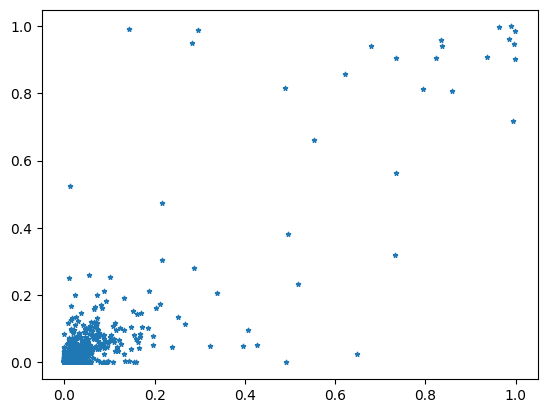

In [222]:
embeddings = get_embedding(q)
M,N = train_msa.shape 
M_ardca = samples_aligned_num.shape[0]
fi_ardca = torch.sum(embeddings(samples_aligned_num), dim=0)/M_ardca
msa_true_emb = embeddings(train_msa)
fi_true=torch.sum(msa_true_emb, dim=0)/M
plt.scatter(fi_true.flatten(), fi_ardca.flatten(), marker="*", s=10)

In [ ]:
### Let us try boost the esm sampler

In [5]:
#########################   UPDATE THIS TO ENHANCE SAMPLING. ###########################################
def Sample_Esm(model, coords, n_samples=100, partial_seq=None, temperature=1.0, confidence=None, device='cpu'):
        """ This sampler works only for one structure!!!"""
        """
        Samples sequences based on multinomial sampling (no beam search).

        Args:
            coords: L x 3 x 3 list representing one backbone
            partial_seq: Optional, partial sequence with mask tokens if part of
                the sequence is known
            temperature: sampling temperature, use low temperature for higher
                sequence recovery and high temperature for higher diversity
            confidence: optional length L list of confidence scores for coordinates
        """

        
        coords = torch.tensor(coords)
        partial_seq = None
        #device = 0
        model=model.to(device)
        temperature=1.0
        L = len(coords)
        # Convert to batch format, this does not work, maybe solve.
        #batch_converter = CoordBatchConverter(self.decoder.dictionary)
        #batch_coords, confidence, _, _, padding_mask = (
        #    batch_converter([(coords, confidence, None)], device=device)
        #)
        batch_coords = torch.zeros((1,L+2,3,3)).to(device)
        batch_coords[0, 1:L+1, :, :] = coords
        batch_coords[0,0,:,:] = torch.inf
        batch_coords[0,L+1,:,:] = torch.inf
    

        #padding_mask = torch.zeros((1,L), dtype=torch.bool).to(device)
        padding_mask = torch.isnan(batch_coords[:,:,0,0]).to(device)
        #print(padding_mask)
        #print(padding_mask.shape)

        #### If you do not have a confidence, which is the standard one padded with zeros at the beginning and end, esm default to ones!
        #### https://github.com/facebookresearch/esm/blob/main/esm/inverse_folding/util.py at line 240
        if confidence is None:
            confidence = torch.ones((1,L+2)).to(device)
            confidence[0,0] = 0
            confidence[0,L+1] = 0
        
        # Run encoder only once
        encoder_out = model.encoder(batch_coords, padding_mask, confidence)

        samples_esm= [0]*n_samples
        for sample in range(n_samples):
            print(f"We are at sample: {sample}", end="\r")
            # Start with prepend token
            mask_idx = model.decoder.dictionary.get_idx('<mask>')
            sampled_tokens = torch.full((1, 1+L), mask_idx, dtype=int).to(device)
            sampled_tokens[0, 0] = model.decoder.dictionary.get_idx('<cath>')
            if partial_seq is not None:
                for i, c in enumerate(partial_seq):
                    sampled_tokens[0, i+1] = model.decoder.dictionary.get_idx(c)
                
            # Save incremental states for faster sampling
            incremental_state = dict()



            # Make sure all tensors are on the same device if a GPU is present
            #if device:
            #    sampled_tokens = sampled_tokens.to(device)

            # Decode one token at a time
            for i in range(1, L+1):
                logits, _ = model.decoder(
                    sampled_tokens[:, :i], 
                    encoder_out,
                    incremental_state=incremental_state,
                )
                logits = logits[0].transpose(0, 1)
                logits /= temperature
                probs = F.softmax(logits, dim=-1)
                if sampled_tokens[0, i] == mask_idx:
                    sampled_tokens[:, i] = torch.multinomial(probs, 1).squeeze(-1)
            sampled_seq = sampled_tokens[0, 1:]
            
            # Convert back to string via lookup
            samples_esm[sample] = ''.join([model.decoder.dictionary.get_tok(a) for a in sampled_seq])
        return samples_esm

#########################   UPDATE THIS TO ENHANCE SAMPLING. ###########################################
def Sample_Esm_batch(model, coords, n_samples=100, partial_seq=None, temperature=1.0, confidence=None, device='cpu'):
        """ Since I do not want to touch the forward functions which are very entangled, I will try the following trick
        to hopefully speed the sampler enough. When I want :n_samples from a single structure, I will copy
        such a structure :n_samples times across the batch dimension, from which he should be able to sample from. 
        This is clearly highly memory inefficient, yet it is more memory efficient than generating one samples at the time
        for :n_samples structures, as there if :n_samples is high I will have a lot of padding across the batch dimension. """
        """
        Samples sequences based on multinomial sampling (no beam search).

        Args:
            coords: L x 3 x 3 list representing one backbone
            partial_seq: Optional, partial sequence with mask tokens if part of
                the sequence is known
            temperature: sampling temperature, use low temperature for higher
                sequence recovery and high temperature for higher diversity
            confidence: optional length L list of confidence scores for coordinates
        """

        
        coords = torch.tensor(coords)
        partial_seq = None
        #device = 0
        model=model.to(device)
        temperature=1.0
        L = len(coords)
        # Convert to batch format, this does not work, maybe solve.
        #batch_converter = CoordBatchConverter(self.decoder.dictionary)
        #batch_coords, confidence, _, _, padding_mask = (
        #    batch_converter([(coords, confidence, None)], device=device)
        #)
        #batch_coords = torch.zeros((1,L+2,3,3)).to(device)
        #batch_coords[0, 1:L+1, :, :] = coords
        #batch_coords[0,0,:,:] = torch.inf
        #batch_coords[0,L+1,:,:] = torch.inf
    

        #padding_mask = torch.zeros((1,L), dtype=torch.bool).to(device)
        padding_mask = torch.isnan(batch_coords[:,:,0,0]).to(device)
        #print(padding_mask)
        #print(padding_mask.shape)

        #### If you do not have a confidence, which is the standard one padded with zeros at the beginning and end, esm default to ones!
        #### https://github.com/facebookresearch/esm/blob/main/esm/inverse_folding/util.py at line 240
        if confidence is None:
            confidence = torch.ones((1,L+2)).to(device)
            confidence[0,0] = 0
            confidence[0,L+1] = 0
        
        # Run encoder only once
        encoder_out = model.encoder(batch_coords, padding_mask, confidence)

        # Start with prepend token
        mask_idx = model.decoder.dictionary.get_idx('<mask>')
        sampled_tokens = torch.full((1, n_samples, 1+L), mask_idx, dtype=int).to(device)
        sampled_tokens[0, :, 0] = model.decoder.dictionary.get_idx('<cath>')

            
        # Save incremental states for faster sampling
        incremental_state = dict()


        # Decode one token at a time
        for i in range(1, L+1):
            logits, _ = model.decoder(
                sampled_tokens[:, :i], 
                encoder_out,
                incremental_state=incremental_state,
            )
            logits = logits[0].transpose(0, 1)
            logits /= temperature
            probs = F.softmax(logits, dim=-1)
            if sampled_tokens[0, i] == mask_idx:
                sampled_tokens[:, i] = torch.multinomial(probs, 1).squeeze(-1)
            sampled_seq = sampled_tokens[0, 1:]
            
            # Convert back to string via lookup
            samples_esm[sample] = ''.join([model.decoder.dictionary.get_tok(a) for a in sampled_seq])
        return samples_esm

In [17]:
samples_esm = Sample_Esm(model, coords, n_samples=1000, device='cpu')

KeyboardInterrupt: 

In [12]:
model.decoder.forward.__globals__['__file__']#.__globals__['__file__']

'/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/esm/esm/inverse_folding/transformer_decoder.py'

#### I want to batch sample 

In [13]:
L

NameError: name 'L' is not defined

In [18]:
def sample_esm_batch(model, coords, n_samples=1000, partial_seq=None, temperature=1.0, confidence=None, device='cpu'):
    """ Since I do not want to touch the forward functions which are very entangled, I will try the following trick
    to hopefully speed the sampler enough. When I want :n_samples from a single structure, I will copy
    such a structure :n_samples times across the batch dimension, from which he should be able to sample from. 
    This is clearly highly memory inefficient, yet it is more memory efficient than generating one samples at the time
    for :n_samples structures, as there if :n_samples is high I will have a lot of padding across the batch dimension. """
    """
    Samples sequences based on multinomial sampling (no beam search).

    Args:
        coords: L x 3 x 3 list representing one backbone
        partial_seq: Optional, partial sequence with mask tokens if part of
            the sequence is known
        temperature: sampling temperature, use low temperature for higher
            sequence recovery and high temperature for higher diversity
        confidence: optional length L list of confidence scores for coordinates
    """

    coords = torch.tensor(coords)

    model=model.to(device)
    temperature=1.0
    L = len(coords)

    batch_coords = torch.zeros((1,L+2,3,3)).to(device)
    batch_coords[0, 1:L+1, :, :] = coords
    batch_coords[0,0,:,:] = torch.inf
    batch_coords[0,L+1,:,:] = torch.inf

    padding_mask = torch.isnan(batch_coords[:,:,0,0]).to(device)


    #### If you do not have a confidence, which is the standard one padded with zeros at the beginning and end, esm default to ones!
    #### https://github.com/facebookresearch/esm/blob/main/esm/inverse_folding/util.py at line 240

    confidence = torch.ones((1,L+2)).to(device)
    confidence[0,0] = 0
    confidence[0,L+1] = 0

    # Run encoder only once
    encoder_out = model.encoder(batch_coords, padding_mask, confidence)

    padding_batched = torch.zeros((n_samples, L+2), dtype=torch.bool)
    encoder_out['encoder_out'][0] = encoder_out['encoder_out'][0].expand(L+2, n_samples, 512)
    encoder_out['encoder_padding_mask'][0] = padding_batched
    ## Now I have to batch some things 

    # Start with prepend token
    mask_idx = model.decoder.dictionary.get_idx('<mask>')
    sampled_tokens = torch.full((n_samples, 1+L), mask_idx, dtype=int).to(device)
    sampled_tokens[:, 0] = model.decoder.dictionary.get_idx('<cath>')


    # Save incremental states for faster sampling
    incremental_state = dict()


    # Decode one token at a time
    for i in range(1, L+1):
        logits, _ = model.decoder(
            sampled_tokens[:, :i], 
            encoder_out,
            incremental_state=incremental_state,
        )
        #logits = logits[0].transpose(0, 1)
        logits = logits.squeeze(-1)#.transpose(0,1)
        logits /= temperature
        probs = F.softmax(logits, dim=-1)
        #if sampled_tokens[0, i] == mask_idx:
        sampled_tokens[:, i] = torch.multinomial(probs, 1).squeeze(-1)
        sampled_seq = sampled_tokens[0, 1:]
        
    samples_esm = torch.zeros(n_samples, L)
    for idx in range(n_samples):
        sampled_seq = sampled_tokens[idx, 1:]
        sampled_str = ''.join([model.decoder.dictionary.get_tok(a) for a in sampled_seq])
        char_idx = 0
        for char in sampled_str:
            samples_esm[idx, char_idx] = aa_index[char]
            char_idx+=1
    return samples_esm 

In [28]:
sample_esm_batch(model, coords)

: 

: 

In [21]:
coords.shape

(43, 3, 3)

In [18]:
""" Since I do not want to touch the forward functions which are very entangled, I will try the following trick
to hopefully speed the sampler enough. When I want :n_samples from a single structure, I will copy
such a structure :n_samples times across the batch dimension, from which he should be able to sample from. 
This is clearly highly memory inefficient, yet it is more memory efficient than generating one samples at the time
for :n_samples structures, as there if :n_samples is high I will have a lot of padding across the batch dimension. """
"""
Samples sequences based on multinomial sampling (no beam search).

Args:
    coords: L x 3 x 3 list representing one backbone
    partial_seq: Optional, partial sequence with mask tokens if part of
        the sequence is known
    temperature: sampling temperature, use low temperature for higher
        sequence recovery and high temperature for higher diversity
    confidence: optional length L list of confidence scores for coordinates
"""
device=0
n_samples=100
coords = torch.tensor(coords)

model=model.to(device)
temperature=1.0
L = len(coords)

batch_coords = torch.zeros((1,L+2,3,3)).to(device)
batch_coords[0, 1:L+1, :, :] = coords
batch_coords[0,0,:,:] = torch.inf
batch_coords[0,L+1,:,:] = torch.inf

with torch.no_grad():
    #padding_mask = torch.zeros((1,L), dtype=torch.bool).to(device)
    padding_mask = torch.isnan(batch_coords[:,:,0,0]).to(device)
    #print(padding_mask)
    #print(padding_mask.shape)

    #### If you do not have a confidence, which is the standard one padded with zeros at the beginning and end, esm default to ones!
    #### https://github.com/facebookresearch/esm/blob/main/esm/inverse_folding/util.py at line 240

    confidence = torch.ones((1,L+2)).to(device)
    confidence[0,0] = 0
    confidence[0,L+1] = 0

    # Run encoder only once
    encoder_out = model.encoder(batch_coords, padding_mask, confidence)

    padding_batched = torch.zeros((n_samples, L+2), dtype=torch.bool).to(device)
    encoder_out['encoder_out'][0] = encoder_out['encoder_out'][0].expand(L+2, n_samples, 512)
    encoder_out['encoder_padding_mask'][0] = padding_batched
    ## Now I have to batch some things 

    # Start with prepend token
    mask_idx = model.decoder.dictionary.get_idx('<mask>')
    sampled_tokens = torch.full((n_samples, 1+L), mask_idx, dtype=int).to(device)
    sampled_tokens[:, 0] = model.decoder.dictionary.get_idx('<cath>')


    # Save incremental states for faster sampling
    incremental_state = dict()
    #samples_esm = torch.zeros(n_samples, L)

    # Decode one token at a time
    for i in range(1, L+1):
        logits, _ = model.decoder(
            sampled_tokens[:, :i], 
            encoder_out,
            incremental_state=incremental_state,
        )
        #logits = logits[0].transpose(0, 1)
        logits = logits.squeeze(-1)#.transpose(0,1)
        logits /= temperature
        probs = F.softmax(logits, dim=-1)
        #if sampled_tokens[0, i] == mask_idx:
        sampled_tokens[:, i] = torch.multinomial(probs, 1).squeeze(-1)
        sampled_seq = sampled_tokens[0, 1:]
        
        # Convert back to string via lookup
        #samples_esm[i] = ''.join([model.decoder.dictionary.get_tok(a) for a in sampled_seq])

/tmp/ipykernel_388976/2400947779.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  coords = torch.tensor(coords)


In [17]:
encoder_out

{'encoder_out': [tensor([[[ 0.5518,  0.4006,  0.1656,  ...,  0.3421, -0.2162, -0.4979],
           [ 0.5518,  0.4006,  0.1656,  ...,  0.3421, -0.2162, -0.4979],
           [ 0.5518,  0.4006,  0.1656,  ...,  0.3421, -0.2162, -0.4979],
           ...,
           [ 0.5518,  0.4006,  0.1656,  ...,  0.3421, -0.2162, -0.4979],
           [ 0.5518,  0.4006,  0.1656,  ...,  0.3421, -0.2162, -0.4979],
           [ 0.5518,  0.4006,  0.1656,  ...,  0.3421, -0.2162, -0.4979]],
  
          [[ 0.2971,  0.2332,  0.0322,  ...,  0.2790,  0.2932, -0.1578],
           [ 0.2971,  0.2332,  0.0322,  ...,  0.2790,  0.2932, -0.1578],
           [ 0.2971,  0.2332,  0.0322,  ...,  0.2790,  0.2932, -0.1578],
           ...,
           [ 0.2971,  0.2332,  0.0322,  ...,  0.2790,  0.2932, -0.1578],
           [ 0.2971,  0.2332,  0.0322,  ...,  0.2790,  0.2932, -0.1578],
           [ 0.2971,  0.2332,  0.0322,  ...,  0.2790,  0.2932, -0.1578]],
  
          [[-0.9711, -0.3768, -0.6929,  ...,  0.5163,  0.2923,  0.324

In [123]:
samples_esm_num = torch.zeros((n_samples, L), dtype=torch.long)
for idx in range(n_samples):
    print(idx, end="\r")
    sampled_str = samples_esm[idx]
    char_idx = 0
    for char in sampled_str:
        samples_esm_num[idx, char_idx] = aa_index[char]
        char_idx+=1


In [115]:
samples_esm2 = torch.zeros(n_samples, L)
for idx in range(n_samples):
    print(idx, end="\r")
    sampled_seq = sampled_tokens[idx, 1:]
    sampled_str = ''.join([model.decoder.dictionary.get_tok(a) for a in sampled_seq])
    char_idx = 0
    for char in sampled_str:
        samples_esm2[idx, char_idx] = aa_index[char]
        char_idx+=1





In [109]:
sampled_tokens.shape

torch.Size([1000, 37])

In [108]:
sampled_tokens

tensor([[33,  6,  9,  ..., 10, 11, 10],
        [33,  9, 11,  ..., 10, 20, 16],
        [33,  6, 14,  ..., 17, 13, 16],
        ...,
        [33, 20, 15,  ..., 10, 11, 16],
        [33, 16, 13,  ..., 10,  9, 16],
        [33,  9,  9,  ..., 10,  5,  8]])

In [125]:
q=21
embeddings = get_embedding(q)
samples_esm_emb = embeddings(samples_esm_num)
samples_esm_emb2 = embeddings(torch.tensor(samples_esm2, dtype=torch.long))

/tmp/ipykernel_308487/2000545160.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  samples_esm_emb2 = embeddings(torch.tensor(samples_esm2, dtype=torch.long))


In [129]:
fi=torch.sum(samples_esm_emb, dim=0)/n_samples
fi2 = torch.sum(samples_esm_emb2, dim=0)/n_samples

(array([  2.,  10.,  21.,  61., 493., 127.,  31.,   6.,   4.,   1.]),
 array([-0.03899997, -0.03069998, -0.02239998, -0.01409998, -0.00579999,
         0.00250001,  0.01080001,  0.01910001,  0.02740001,  0.0357    ,
         0.044     ]),
 <BarContainer object of 10 artists>)

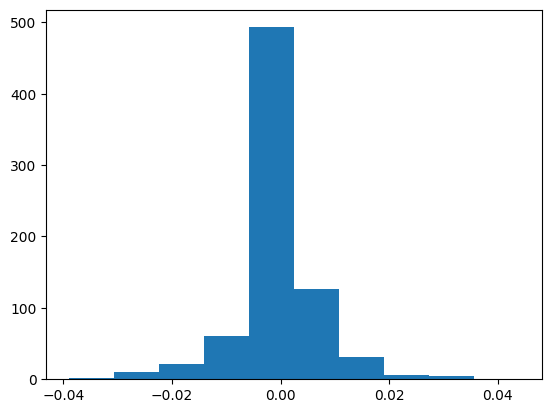

In [137]:
plt.hist(fi.flatten() - fi2.flatten())

In [133]:
fi2[0,:]

tensor([0.1060, 0.0100, 0.0640, 0.0630, 0.0140, 0.2760, 0.0330, 0.0180, 0.0530,
        0.0230, 0.0690, 0.0570, 0.0170, 0.0330, 0.0240, 0.0660, 0.0240, 0.0320,
        0.0040, 0.0140, 0.0000])

In [ ]:
fi

In [25]:
#coords

In [21]:
class BatchConverter(object):
    """Callable to convert an unprocessed (labels + strings) batch to a
    processed (labels + tensor) batch.
    """

    def __init__(self, alphabet, truncation_seq_length: int = None):
        self.alphabet = alphabet
        self.truncation_seq_length = truncation_seq_length

    def __call__(self, raw_batch: Sequence[Tuple[str, str]]):
        # RoBERTa uses an eos token, while ESM-1 does not.
        batch_size = len(raw_batch)
        batch_labels, seq_str_list = zip(*raw_batch)   ## Problem here
        seq_encoded_list = [self.alphabet.encode(seq_str) for seq_str in seq_str_list]
        if self.truncation_seq_length:
            seq_encoded_list = [seq_str[:self.truncation_seq_length] for seq_str in seq_encoded_list]
        max_len = max(len(seq_encoded) for seq_encoded in seq_encoded_list)
        tokens = torch.empty(
            (
                batch_size,
                max_len + int(self.alphabet.prepend_bos) + int(self.alphabet.append_eos),
            ),
            dtype=torch.int64,
        )
        tokens.fill_(self.alphabet.padding_idx)
        labels = []
        strs = []

        for i, (label, seq_str, seq_encoded) in enumerate(
            zip(batch_labels, seq_str_list, seq_encoded_list)
        ):
            labels.append(label)
            strs.append(seq_str)
            if self.alphabet.prepend_bos:
                tokens[i, 0] = self.alphabet.cls_idx
            seq = torch.tensor(seq_encoded, dtype=torch.int64)
            tokens[
                i,
                int(self.alphabet.prepend_bos) : len(seq_encoded)
                + int(self.alphabet.prepend_bos),
            ] = seq
            if self.alphabet.append_eos:
                tokens[i, len(seq_encoded) + int(self.alphabet.prepend_bos)] = self.alphabet.eos_idx

        return labels, strs, tokens


class CoordBatchConverter(BatchConverter):
    def __call__(self, raw_batch: Sequence[Tuple[Sequence, str]], device=None):
        """
        Args:
            raw_batch: List of tuples (coords, confidence, seq)
            In each tuple,
                coords: list of floats, shape L x 3 x 3
                confidence: list of floats, shape L; or scalar float; or None
                seq: string of length L
        Returns:
            coords: Tensor of shape batch_size x L x 3 x 3
            confidence: Tensor of shape batch_size x L
            strs: list of strings
            tokens: LongTensor of shape batch_size x L
            padding_mask: ByteTensor of shape batch_size x L
        """
        self.alphabet.cls_idx = self.alphabet.get_idx("<cath>") 
        batch = []
        for coords, confidence, seq in raw_batch:
            if confidence is None:
                confidence = 1.
            if isinstance(confidence, float) or isinstance(confidence, int):
                confidence = [float(confidence)] * len(coords)
            if seq is None:
                seq = 'X' * len(coords)
            batch.append(((coords, confidence), seq))

        coords_and_confidence, strs, tokens = super().__call__(batch)

        # pad beginning and end of each protein due to legacy reasons
        coords = [
            F.pad(torch.tensor(cd), (0, 0, 0, 0, 1, 1), value=np.inf)
            for cd, _ in coords_and_confidence
        ]
        confidence = [
            F.pad(torch.tensor(cf), (1, 1), value=-1.)
            for _, cf in coords_and_confidence
        ]
        coords = self.collate_dense_tensors(coords, pad_v=np.nan)
        confidence = self.collate_dense_tensors(confidence, pad_v=-1.)
        if device is not None:
            coords = coords.to(device)
            confidence = confidence.to(device)
            tokens = tokens.to(device)
        padding_mask = torch.isnan(coords[:,:,0,0])
        coord_mask = torch.isfinite(coords.sum(-2).sum(-1))
        confidence = confidence * coord_mask + (-1.) * padding_mask
        return coords, confidence, strs, tokens, padding_mask

    def from_lists(self, coords_list, confidence_list=None, seq_list=None, device=None):
        """
        Args:
            coords_list: list of length batch_size, each item is a list of
            floats in shape L x 3 x 3 to describe a backbone
            confidence_list: one of
                - None, default to highest confidence
                - list of length batch_size, each item is a scalar
                - list of length batch_size, each item is a list of floats of
                    length L to describe the confidence scores for the backbone
                    with values between 0. and 1.
            seq_list: either None or a list of strings
        Returns:
            coords: Tensor of shape batch_size x L x 3 x 3
            confidence: Tensor of shape batch_size x L
            strs: list of strings
            tokens: LongTensor of shape batch_size x L
            padding_mask: ByteTensor of shape batch_size x L
        """
        batch_size = len(coords_list)
        if confidence_list is None:
            confidence_list = [None] * batch_size
        if seq_list is None:
            seq_list = [None] * batch_size
        raw_batch = zip(coords_list, confidence_list, seq_list)
        return self.__call__(raw_batch, device)

    @staticmethod
    def collate_dense_tensors(samples, pad_v):
        """
        Takes a list of tensors with the following dimensions:
            [(d_11,       ...,           d_1K),
             (d_21,       ...,           d_2K),
             ...,
             (d_N1,       ...,           d_NK)]
        and stack + pads them into a single tensor of:
        (N, max_i=1,N { d_i1 }, ..., max_i=1,N {diK})
        """
        if len(samples) == 0:
            return torch.Tensor()
        if len(set(x.dim() for x in samples)) != 1:
            raise RuntimeError(
                f"Samples has varying dimensions: {[x.dim() for x in samples]}"
            )
        (device,) = tuple(set(x.device for x in samples))  # assumes all on same device
        max_shape = [max(lst) for lst in zip(*[x.shape for x in samples])]
        result = torch.empty(
            len(samples), *max_shape, dtype=samples[0].dtype, device=device
        )
        result.fill_(pad_v)
        for i in range(len(samples)):
            result_i = result[i]
            t = samples[i]
            result_i[tuple(slice(0, k) for k in t.shape)] = t
        return result
    

In [24]:
n_samples = 100
coords = torch.tensor(coords)

coords_list = [coords]*n_samples
batch_converter = CoordBatchConverter.from_lists(model, coords_list=coords_list, device='cpu')
#device = 0
#model=model.to(device)
temperature=1.0
L = len(coords)
#Convert to batch format, this does not work, maybe solve.
batch_converter = CoordBatchConverter(model.decoder.dictionary)
#batch_coords, confidence, _, _, padding_mask = (
#    batch_converter([(coords, confidence, None)], device=device)
#)

/tmp/ipykernel_308487/1573905127.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  coords = torch.tensor(coords)


TypeError: forward() missing 2 required positional arguments: 'confidence' and 'prev_output_tokens'

## SEEMS VERY HARD TO BATCH THIS SAMPLER... I WOULD NEED TO GET INSIDE THE FORWARD FUNCTION...

In [34]:
 logits, _ = model.decoder(
    sampled_tokens[:, :1], 
    encoder_out,
    incremental_state=incremental_state,
)

ValueError: too many values to unpack (expected 2)

In [ ]:
# Decode one token at a time, for n_samples though!
for i in range(1, L+1):
    logits, _ = model.decoder(
        sampled_tokens[:, :i], 
        encoder_out,
        incremental_state=incremental_state,
    )
    logits = logits[0].transpose(0, 1)
    logits /= temperature
    probs = F.softmax(logits, dim=-1)
    if sampled_tokens[0, i] == mask_idx:
        sampled_tokens[:, i] = torch.multinomial(probs, 1).squeeze(-1)
sampled_seq = sampled_tokens[0, 1:]

# Convert back to string via lookup
samples_esm[sample] = ''.join([model.decoder.dictionary.get_tok(a) for a in sampled_seq])
#return samples_esm